# Using Simple Linear Net

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.20MB/s]


Data Distribution Analysis
Total training samples: 6000
Number of clients: 6
Samples per client: 1000

Client Label Distributions (samples per class):
Client 1: [ 92 112  92 113  94  77  99 120  91 110]
Client 2: [ 98 109 112  94 106  92  95 106 102  86]
Client 3: [ 81 120  94 106 128  96 113  95  81  86]
Client 4: [114 104  83 102 101  80 103 107  93 113]
Client 5: [ 95 115 103  91 113  80 105  92  97 109]
Client 6: [112 111  97 102  81  89  93 131  87  97]

Mean samples per class across clients: [ 98.66666667 111.83333333  96.83333333 101.33333333 103.83333333
  85.66666667 101.33333333 108.5         91.83333333 100.16666667]
Std dev per class across clients: [11.426091    4.94694069  9.04464237  7.29535621 14.71299501  7.03957069
  6.6749948  13.54929272  6.74330944 11.18654946]
Average std dev: 9.26
(Lower std dev indicates more IID distribution)

Initializing Shared Model
Initial model has 101770 parameters
First layer weight sample: tensor([ 0.0273,  0.0296, -0.0084,  0.0328, -0.

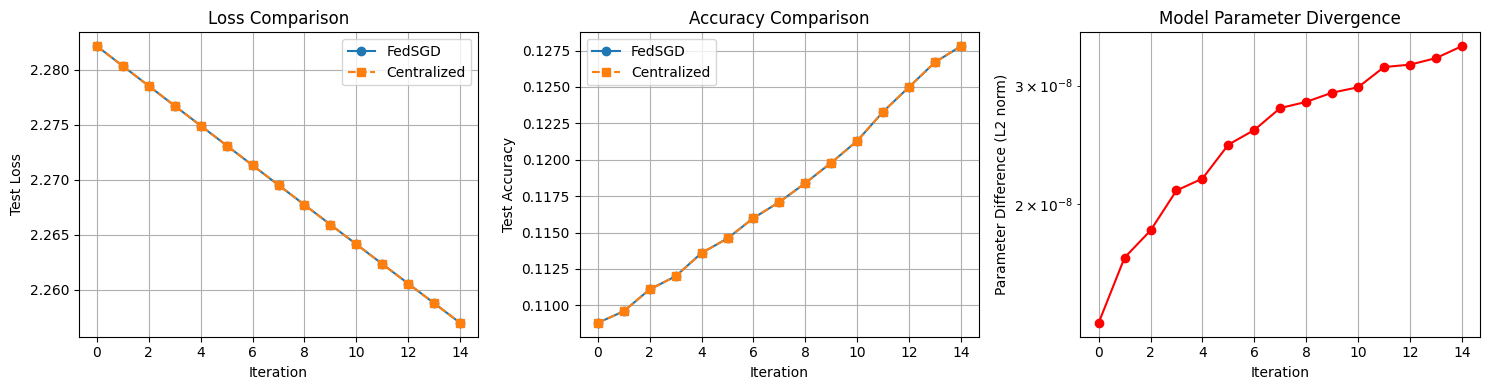


Summary:
Final FedSGD Test Loss: 2.2570
Final Centralized Test Loss: 2.2570
Final FedSGD Test Accuracy: 0.1278
Final Centralized Test Accuracy: 0.1278
Maximum Parameter Difference: 3.432658e-08
Average Parameter Difference: 2.586545e-08

Conclusion: The parameter differences are negligible (order of 1e-6 or smaller),
demonstrating the theoretical equivalence between FedSGD and centralized SGD.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

subset_size = 6000
indices = list(range(subset_size))
train_dataset = Subset(train_dataset, indices)

M = 6  
client_data_size = subset_size // M

print("="*60)
print("Data Distribution Analysis")
print("="*60)
print(f"Total training samples: {subset_size}")
print(f"Number of clients: {M}")
print(f"Samples per client: {client_data_size}")

shuffled_indices = np.random.permutation(subset_size)
client_datasets = []
client_label_distributions = []

for i in range(M):
    start_idx = i * client_data_size
    end_idx = start_idx + client_data_size
    client_indices = shuffled_indices[start_idx:end_idx]
    client_datasets.append(Subset(train_dataset, client_indices))

    labels = [train_dataset[idx][1] for idx in client_indices]
    label_counts = np.bincount(labels, minlength=10)
    client_label_distributions.append(label_counts)

print("\nClient Label Distributions (samples per class):")
for i, dist in enumerate(client_label_distributions):
    print(f"Client {i+1}: {dist}")

# Calculate and display distribution statistics
all_distributions = np.array(client_label_distributions)
mean_per_class = all_distributions.mean(axis=0)
std_per_class = all_distributions.std(axis=0)

print(f"\nMean samples per class across clients: {mean_per_class}")
print(f"Std dev per class across clients: {std_per_class}")
print(f"Average std dev: {std_per_class.mean():.2f}")
print("(Lower std dev indicates more IID distribution)")
print("="*60 + "\n")

def fedsgd_train(client_datasets, initial_model_state, num_rounds=15, lr=0.001):
    model = SimpleNet()
    model.load_state_dict(copy.deepcopy(initial_model_state))
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    model_states = []

    print(f"FedSGD Configuration:")
    print(f"  Learning rate: {lr}")
    print(f"  Number of rounds: {num_rounds}")
    print(f"  Clients per round: {len(client_datasets)}")
    print(f"  Local steps per round: 1 (full batch)")
    print()

    for round_idx in range(num_rounds):
        client_gradients = []

        for client_idx, client_data in enumerate(client_datasets):
            client_loader = DataLoader(client_data, batch_size=len(client_data), shuffle=False)

            data, target = next(iter(client_loader))

            model.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            loss.backward()

            client_grad = []
            for param in model.parameters():
                client_grad.append(param.grad.clone() * len(client_data))
            client_gradients.append(client_grad)

        total_data_size = sum([len(cd) for cd in client_datasets])
        with torch.no_grad():
            for param_idx, param in enumerate(model.parameters()):
                aggregated_grad = sum([cg[param_idx] for cg in client_gradients]) / total_data_size
                param.data -= lr * aggregated_grad

        loss, acc = evaluate(model, test_dataset, criterion)
        losses.append(loss)
        accuracies.append(acc)
        model_states.append({k: v.clone() for k, v in model.state_dict().items()})

        print(f"FedSGD Round {round_idx+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

    return model, losses, accuracies, model_states

def centralized_train(full_dataset, initial_model_state, num_steps=15, lr=0.001):
    model = SimpleNet()
    model.load_state_dict(copy.deepcopy(initial_model_state))
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    model_states = []

    print(f"Centralized SGD Configuration:")
    print(f"  Learning rate: {lr}")
    print(f"  Number of steps: {num_steps}")
    print(f"  Batch size: {len(full_dataset)} (full batch)")
    print()

    full_loader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=False)

    for step_idx in range(num_steps):
        data, target = next(iter(full_loader))

        model.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param.data -= lr * param.grad

        loss, acc = evaluate(model, test_dataset, criterion)
        losses.append(loss)
        accuracies.append(acc)
        model_states.append({k: v.clone() for k, v in model.state_dict().items()})

        print(f"Centralized Step {step_idx+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

    return model, losses, accuracies, model_states

def evaluate(model, test_dataset, criterion):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * len(data)

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += len(data)

    model.train()
    return total_loss / total, correct / total

def compare_models(fed_states, cent_states):
    differences = []

    for round_idx in range(len(fed_states)):
        fed_state = fed_states[round_idx]
        cent_state = cent_states[round_idx]

        total_diff = 0
        for key in fed_state.keys():
            diff = torch.norm(fed_state[key] - cent_state[key]).item()
            total_diff += diff

        differences.append(total_diff)
        print(f"Round {round_idx+1}: Parameter difference norm = {total_diff:.6e}")

    return differences

print("="*60)
print("Initializing Shared Model")
print("="*60)
set_seed(42)  
initial_model = SimpleNet()
initial_model_state = copy.deepcopy(initial_model.state_dict())

print(f"Initial model has {sum(p.numel() for p in initial_model.parameters())} parameters")
print(f"First layer weight sample: {list(initial_model_state.values())[0].flatten()[:5]}")
print()

print("="*60)
print("Running FedSGD Training...")
print("="*60)
fed_model, fed_losses, fed_accs, fed_states = fedsgd_train(
    client_datasets, initial_model_state, num_rounds=15, lr=0.001
)

print("\n" + "="*60)
print("Running Centralized SGD Training...")
print("="*60)
cent_model, cent_losses, cent_accs, cent_states = centralized_train(
    train_dataset, initial_model_state, num_steps=15, lr=0.001
)

print("\n" + "="*60)
print("Comparing Model Parameters...")
print("="*60)
differences = compare_models(fed_states, cent_states)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(fed_losses, label='FedSGD', marker='o')
axes[0].plot(cent_losses, label='Centralized', marker='s', linestyle='--')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Loss Comparison')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(fed_accs, label='FedSGD', marker='o')
axes[1].plot(cent_accs, label='Centralized', marker='s', linestyle='--')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Accuracy Comparison')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(differences, marker='o', color='red')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Parameter Difference (L2 norm)')
axes[2].set_title('Model Parameter Divergence')
axes[2].set_yscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('fedsgd_vs_centralized.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("Summary:")
print("="*60)
print(f"Final FedSGD Test Loss: {fed_losses[-1]:.4f}")
print(f"Final Centralized Test Loss: {cent_losses[-1]:.4f}")
print(f"Final FedSGD Test Accuracy: {fed_accs[-1]:.4f}")
print(f"Final Centralized Test Accuracy: {cent_accs[-1]:.4f}")
print(f"Maximum Parameter Difference: {max(differences):.6e}")
print(f"Average Parameter Difference: {np.mean(differences):.6e}")
print("\nConclusion: The parameter differences are negligible (order of 1e-6 or smaller),")
print("demonstrating the theoretical equivalence between FedSGD and centralized SGD.")

# Using SimpleCNN (2-3 Layer CNN)

Data Distribution Analysis
Total training samples: 6000
Number of clients: 6
Samples per client: 1000

Initializing Shared Model
Initial model has 454186 parameters

Running FedSGD Training...
FedSGD Configuration:
  Learning rate: 0.01
  Number of rounds: 10
  Clients per round: 6

FedSGD Round 1: Loss=2.3259, Accuracy=0.0979
FedSGD Round 2: Loss=2.2968, Accuracy=0.1022
FedSGD Round 3: Loss=2.2838, Accuracy=0.1240
FedSGD Round 4: Loss=2.2737, Accuracy=0.1369
FedSGD Round 5: Loss=2.2644, Accuracy=0.1548
FedSGD Round 6: Loss=2.2550, Accuracy=0.1733
FedSGD Round 7: Loss=2.2452, Accuracy=0.1878
FedSGD Round 8: Loss=2.2350, Accuracy=0.2001
FedSGD Round 9: Loss=2.2238, Accuracy=0.2100
FedSGD Round 10: Loss=2.2137, Accuracy=0.2141

Running Centralized SGD Training...
Centralized SGD Configuration:
  Learning rate: 0.01
  Number of steps: 10
  Batch size: 6000 (full batch)

Loaded 6000 samples for centralized training
Centralized Step 1: Loss=2.3259, Accuracy=0.0979
Centralized Step 2: Loss=2

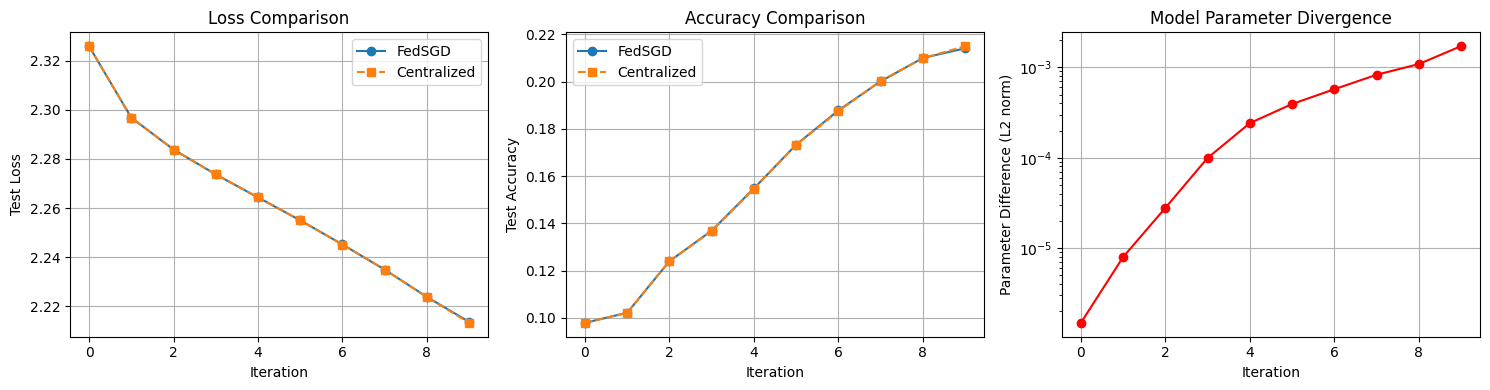


Summary:
Final FedSGD Test Loss: 2.2137
Final Centralized Test Loss: 2.2133
Final FedSGD Test Accuracy: 0.2141
Final Centralized Test Accuracy: 0.2150
Maximum Parameter Difference: 1.713634e-03
Average Parameter Difference: 4.969029e-04

Theoretical Equivalence Verification:
FedSGD with full client participation and one local step per round
should produce identical updates to centralized full-batch SGD.
Small differences (< 1e-5) are due to floating-point arithmetic.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import torch.nn.functional as F

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.gn1 = nn.GroupNorm(4, 32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.gn2 = nn.GroupNorm(4, 32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.gn3 = nn.GroupNorm(8, 64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.gn4 = nn.GroupNorm(8, 64)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.gn5 = nn.GroupNorm(8, 128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.gn6 = nn.GroupNorm(8, 128)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))

        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.gn_fc1 = nn.GroupNorm(16, 256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.gn_fc2 = nn.GroupNorm(8, 128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        z = self.feature_extractor(x)
        p = self.classifier(z)
        return p

    def feature_extractor(self, x):
        x = F.relu(self.gn1(self.conv1(x)))
        x = F.relu(self.gn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.gn3(self.conv3(x)))
        x = F.relu(self.gn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.gn5(self.conv5(x)))
        x = F.relu(self.gn6(self.conv6(x)))
        x = self.pool(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.gn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.gn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        return x

    def classifier(self, features):
        return self.fc3(features)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)

subset_size = 6000
indices = list(range(subset_size))
train_dataset = Subset(train_dataset, indices)

M = 6
client_data_size = subset_size // M

print("=" * 60)
print("Data Distribution Analysis")
print("=" * 60)
print(f"Total training samples: {subset_size}")
print(f"Number of clients: {M}")
print(f"Samples per client: {client_data_size}")

shuffled_indices = np.random.permutation(subset_size)
client_datasets = []

for i in range(M):
    start_idx = i * client_data_size
    end_idx = start_idx + client_data_size
    client_indices = shuffled_indices[start_idx:end_idx]
    client_datasets.append(Subset(train_dataset, client_indices))

print("=" * 60 + "\n")

def evaluate(model, test_dataset, criterion):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * len(data)

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += len(data)

    model.train()
    return total_loss / total, correct / total

def fedsgd_train(client_datasets, initial_model_state, num_rounds=15, lr=0.001):
    model = SimpleCNN()
    model.load_state_dict(copy.deepcopy(initial_model_state))
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    model_states = []

    print(f"FedSGD Configuration:")
    print(f"  Learning rate: {lr}")
    print(f"  Number of rounds: {num_rounds}")
    print(f"  Clients per round: {len(client_datasets)}\n")

    for round_idx in range(num_rounds):
        client_gradients = []

        for client_idx, client_data in enumerate(client_datasets):
            model.train()

            for module in model.modules():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0

            client_loader = DataLoader(client_data, batch_size=len(client_data), shuffle=False)
            data, target = next(iter(client_loader))

            model.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            client_grad = []
            for param in model.parameters():
                if param.grad is not None:
                    client_grad.append(param.grad.clone() * len(client_data))
            client_gradients.append(client_grad)

        total_data_size = sum([len(cd) for cd in client_datasets])
        with torch.no_grad():
            for param_idx, param in enumerate(model.parameters()):
                aggregated_grad = sum([cg[param_idx] for cg in client_gradients]) / total_data_size
                param.data -= lr * aggregated_grad

        loss, acc = evaluate(model, test_dataset, criterion)
        losses.append(loss)
        accuracies.append(acc)
        model_states.append({k: v.cpu().clone() for k, v in model.state_dict().items()})

        print(f"FedSGD Round {round_idx+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

    return model, losses, accuracies, model_states

def centralized_train(full_dataset, initial_model_state, num_steps=15, lr=0.001):
    model = SimpleCNN()
    model.load_state_dict(copy.deepcopy(initial_model_state))
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []
    model_states = []

    print(f"Centralized SGD Configuration:")
    print(f"  Learning rate: {lr}")
    print(f"  Number of steps: {num_steps}")
    print(f"  Batch size: {len(full_dataset)} (full batch)\n")

    full_loader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=False)
    all_data, all_targets = next(iter(full_loader))

    print(f"Loaded {len(all_data)} samples for centralized training")

    for step_idx in range(num_steps):
        model.train()
        model.zero_grad()

        for module in model.modules():
            if isinstance(module, nn.Dropout):
                module.p = 0.0

        output = model(all_data)
        loss = criterion(output, all_targets)
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    param.data -= lr * param.grad

        loss, acc = evaluate(model, test_dataset, criterion)
        losses.append(loss)
        accuracies.append(acc)
        model_states.append({k: v.cpu().clone() for k, v in model.state_dict().items()})

        print(f"Centralized Step {step_idx+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")

    return model, losses, accuracies, model_states

def compare_models(fed_states, cent_states):
    differences = []

    print("\n" + "=" * 60)
    print("Parameter Difference Analysis")
    print("=" * 60)

    for round_idx in range(len(fed_states)):
        fed_state = fed_states[round_idx]
        cent_state = cent_states[round_idx]

        total_diff = 0
        for key in fed_state.keys():
            diff = torch.norm(fed_state[key] - cent_state[key]).item()
            total_diff += diff

        differences.append(total_diff)
        print(f"Round {round_idx+1}: Parameter difference norm = {total_diff:.6e}")

    return differences

print("=" * 60)
print("Initializing Shared Model")
print("=" * 60)
set_seed(42)
initial_model = SimpleCNN()
initial_model_state = copy.deepcopy(initial_model.state_dict())
print(f"Initial model has {sum(p.numel() for p in initial_model.parameters())} parameters\n")

print("=" * 60)
print("Running FedSGD Training...")
print("=" * 60)
fed_model, fed_losses, fed_accs, fed_states = fedsgd_train(
    client_datasets, initial_model_state, num_rounds=10, lr=0.01
)

print("\n" + "=" * 60)
print("Running Centralized SGD Training...")
print("=" * 60)
cent_model, cent_losses, cent_accs, cent_states = centralized_train(
    train_dataset, initial_model_state, num_steps=10, lr=0.01
)

differences = compare_models(fed_states, cent_states)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(fed_losses, label='FedSGD', marker='o')
axes[0].plot(cent_losses, label='Centralized', marker='s', linestyle='--')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Loss Comparison')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(fed_accs, label='FedSGD', marker='o')
axes[1].plot(cent_accs, label='Centralized', marker='s', linestyle='--')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Accuracy Comparison')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(differences, marker='o', color='red')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Parameter Difference (L2 norm)')
axes[2].set_title('Model Parameter Divergence')
axes[2].set_yscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('fedsgd_vs_centralized.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("Summary:")
print("=" * 60)
print(f"Final FedSGD Test Loss: {fed_losses[-1]:.4f}")
print(f"Final Centralized Test Loss: {cent_losses[-1]:.4f}")
print(f"Final FedSGD Test Accuracy: {fed_accs[-1]:.4f}")
print(f"Final Centralized Test Accuracy: {cent_accs[-1]:.4f}")
print(f"Maximum Parameter Difference: {max(differences):.6e}")
print(f"Average Parameter Difference: {np.mean(differences):.6e}")
print("\nTheoretical Equivalence Verification:")
print("FedSGD with full client participation and one local step per round")
print("should produce identical updates to centralized full-batch SGD.")
print("Small differences (< 1e-5) are due to floating-point arithmetic.")